In [1]:
using Raytracing
using PyPlot
using Images

In [2]:
rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
rcParams["font.size"] = 10
minval = 0.5
maxval = 1.0
dpi = 200
cmap = get_cmap("PuOr")
violett = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
cmap = get_cmap("seismic")
red = PyPlot.matplotlib.colors.LinearSegmentedColormap.from_list(
             "trunc("*cmap.name*", "*string(minval)*", "*string(maxval)*")",
             cmap(range(minval, maxval, length=cmap.N)))
;

In [3]:
c = 299792458           # the speed of light
ħ = 1.054571817e-34     # the reduced planck constant
m_e = 9.1093837015e-31  # the electron mass
q = 1.602176634e-19     # electron charge
ε_0 = 8.8541878128e-12  # vacuum permitivity
;

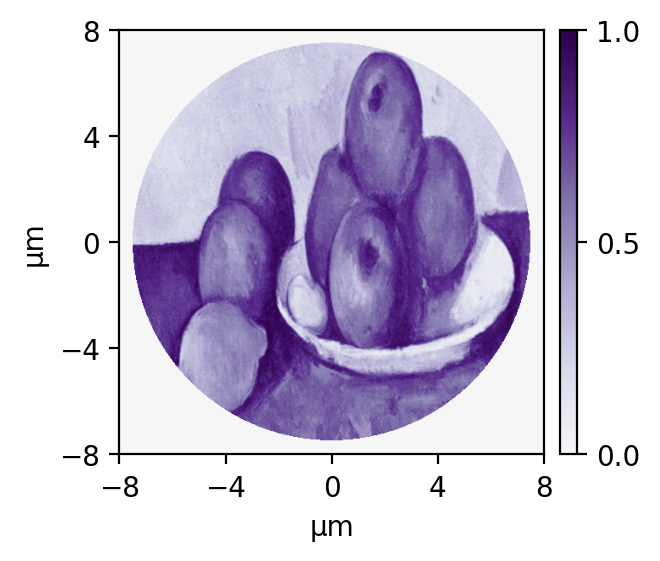

In [4]:
xmin = -8e-6
xmax =  8e-6
ymin = -8e-6
ymax =  8e-6

nx = 501
ny = 501

debeam = 15e-6

x = Vector{Float64}(range(xmin, xmax, length=nx))
y = Vector{Float64}(range(ymin, ymax, length=ny))

aperture = [x[i]^2+y[j]^2 < debeam^2/4 ? 1. : 0. for i in eachindex(x), j in eachindex(y)]

img = Float64.(imresize(Gray.(-1*load("./images/sample_image.png")), (501, 501))) .+ 1

inint = img .* aperture
inint ./= maximum(inint)

inputextent = [x[1], x[end], y[1], y[end]] .* 1e6

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)

plt = ax.imshow(inint, cmap=violett, extent=inputextent)

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

ax.set_xticks([-8, -4, 0, 4, 8])
ax.set_yticks([-8, -4, 0, 4, 8])

savefig("./images/lens/input.svg", bbox_inches="tight", dpi=dpi)

In [5]:
U = 30e3
z = 0.5
λ_L = 1035e-9
N = 5e6

f = 0.01

v = c * sqrt(1 - 1 / (1 + q*U/m_e/c^2)^2)
α = 1 / (4 * π * ε_0) * q^2 / (ħ * c)
β = v / c
γ = 1 / sqrt(1 - β^2)
Ee = γ*m_e*c^2
λ_e = 2 * π * ħ / (γ * m_e * v)
;

In [6]:
# LG10 effective lens size: 0.2295 * w
lg10(ρ, w) = @. 2 * ρ^2 / w^2 * exp(-2*ρ^2/w^2)
e10(f, w) = (1+β) * π^3 * w^4 * Ee / (2 * α * λ_L^2 * λ_e) / f
w10(f, E) = ( 2 * α * λ_L^2 * λ_e * f * E / ( (1+β) * π^3 * Ee) )^(1/4)

# modified LG10 effective lens size: 0.5157 * w
modLG(ρ, w) = @. 2 * ρ^2 / w^2 * (1 + 2 * ρ^2 / w^2) * exp(-2*ρ^2/w^2)
emod(f, w) = (1+β) * 3 * π^3 * w^4 * Ee / (2 * α * λ_L^2 * λ_e) / f
wmod(f, E) = ( 2 * α * λ_L^2 * λ_e * f * E / ( 3*(1+β) * π^3 * Ee) )^(1/4)
;

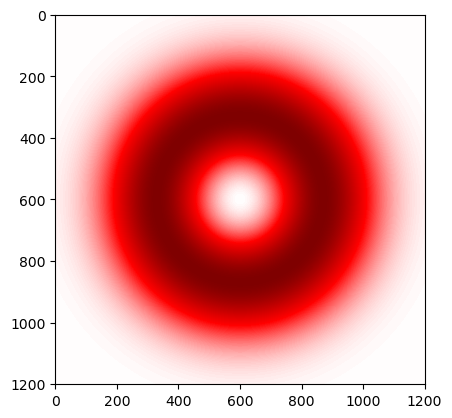

In [7]:
fov = 120e-6
Δxin = 0.1e-6
Δyin = 0.1e-6

w = 30e-6

xin = Vector{Float64}(range(-fov/2, fov/2, step=Δxin))
yin = Vector{Float64}(range(-fov/2, fov/2, step=Δyin))

ρ = @. sqrt(xin^2 + yin'^2)

intextent = [xin[1], xin[end], yin[1], yin[end]] .* 1e6

imshow(modLG(ρ, w), cmap=red)
;

In [8]:
# perfect lens simulation
eb = Electron(x, y, inint, U, Int(N))
lens = Lens(f)
free = Free(z)
setup = Setup(lens, free)
propagation!(eb, setup)
;

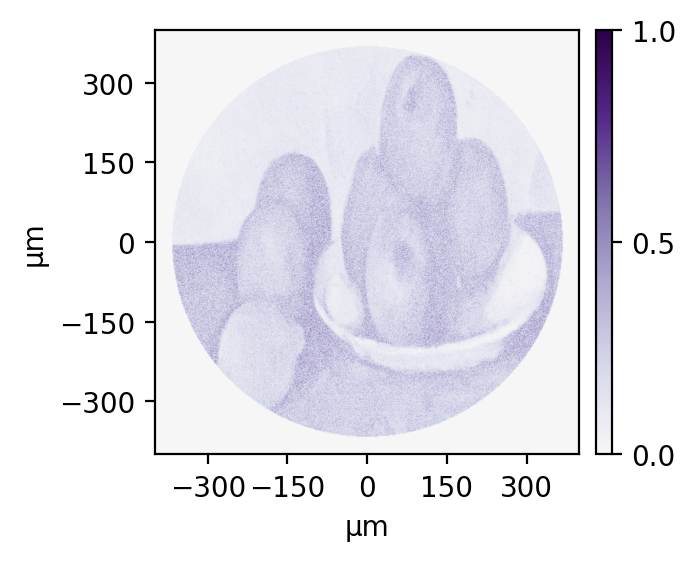

In [9]:
fovimg = 0.8e-3
Δximg = 1e-6
ximg = Vector{Float64}(range(-fovimg/2, fovimg/2-Δximg, step=Δximg))
yimg = copy(ximg)

out_int = getintensity(eb, ximg, yimg)

out_int ./= maximum(out_int)

extent = [ximg[1], ximg[end], yimg[1], yimg[end]] .* 1e6

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)

plt = ax.imshow(out_int[end:-1:1, end:-1:1], cmap=violett, extent=extent)

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_yticks([-300, -150, 0, 150, 300])

savefig("./images/lens/perfect.svg", bbox_inches="tight", dpi=dpi)
;

In [10]:
# lg10 lens simulation
E = 1.28e-3
w = 25e-6
intensity = lg10(ρ, w)
norm = sum(intensity) * Δxin * Δyin
E = e10(f, w)
lf = LightField(intensity, norm, xin, yin, λ_L, E)

eb = Electron(x, y, inint, U, Int(N))
lens = PondInteraction(lf)
free = Free(z)
setup = Setup(lens, free)
propagation!(eb, setup)
;

1278.095327823601

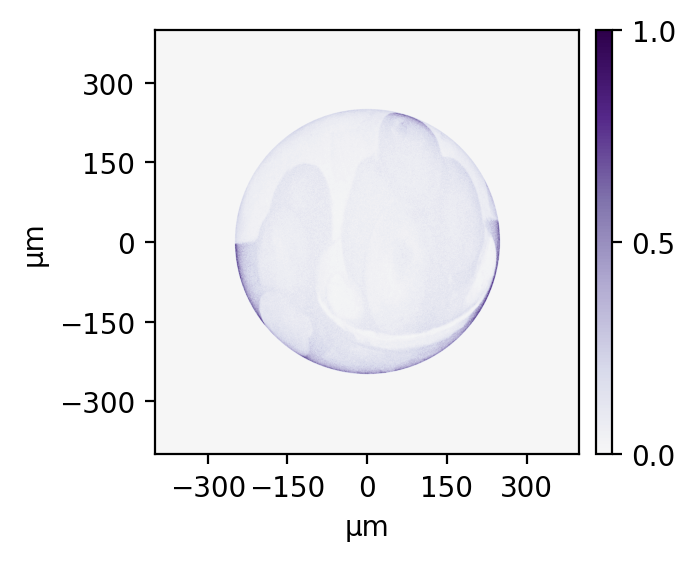

In [11]:
display(E*1e6)
out_int = getintensity(eb, ximg, yimg)

out_int ./= maximum(out_int)

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)

plt = ax.imshow(out_int[end:-1:1, end:-1:1], cmap=violett, extent=extent)

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_yticks([-300, -150, 0, 150, 300])

savefig("./images/lens/lg10.svg", bbox_inches="tight", dpi=dpi)
;

In [12]:
# lg10 lens simulation
w = 19e-6
E = 1.28e-3
intensity = modLG(ρ, w)
norm = sum(intensity) * Δxin * Δyin
E = emod(f, w)
lf = LightField(intensity, norm, xin, yin, λ_L, E)

eb = Electron(x, y, inint, U, Int(N))
lens = PondInteraction(lf)
free = Free(z)
setup = Setup(lens, free)
propagation!(eb, setup)
;

1279.2012381488605

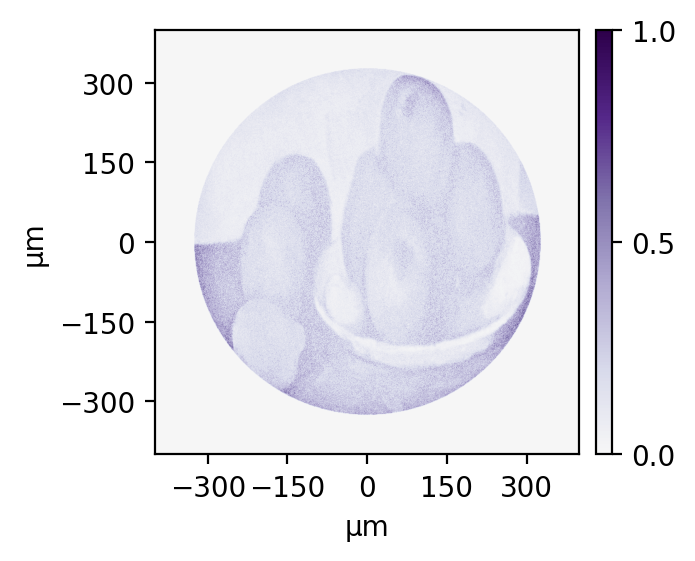

In [13]:
display(E*1e6)
out_int = getintensity(eb, ximg, yimg)

out_int ./= maximum(out_int)

figsize = [7, 7] ./ 2.54

pygui(false)
fig, ax = subplots(figsize=figsize, dpi=dpi)

plt = ax.imshow(out_int[end:-1:1, end:-1:1], cmap=violett, extent=extent)

cax = fig.add_axes([ax.get_position().x1+0.03,ax.get_position().y0,0.03,ax.get_position().height])
fig.colorbar(plt, ax=ax, shrink=0.8, ticks=[0, 0.5, 1], cax=cax)

ax.set_xlabel("µm")
ax.set_ylabel("µm")

ax.set_xticks([-300, -150, 0, 150, 300])
ax.set_yticks([-300, -150, 0, 150, 300])

savefig("./images/lens/modlg.svg", bbox_inches="tight", dpi=dpi)
;